In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [4]:
votes = pd.read_csv('114_US_Senate_binVotes.csv', index_col=0)

In [220]:
mask = ~((votes.columns.str.slice(-3, -1) == 'AK') ^ (votes.columns.str.slice(-3, -1) == 'HI'))
votes = votes.T[mask].T

In [221]:
from sklearn.decomposition import PCA

In [222]:
pca = PCA(5)

In [223]:
Y = pca.fit_transform(votes.T)

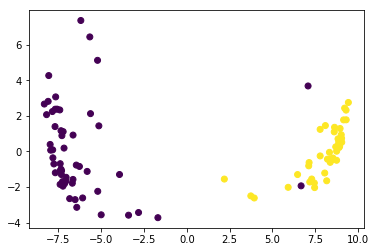

In [224]:
plt.scatter(Y[:, 0], Y[:, 1], c=votes.columns.str.get(-5)=='D')

In [225]:
states = pd.read_csv('states.csv', index_col=-1)

In [226]:
states = states.loc[votes.columns.str.slice(-3, -1)]

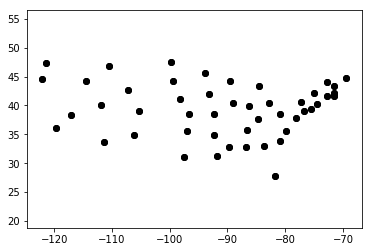

In [231]:
plt.scatter(states.Longitude, states.Latitude, c='k')
plt.axis('equal');

In [232]:
adjecency_list = \
'''AK
AL,MS,TN,GA,FL
AR,MO,TN,MS,LA,TX,OK
AZ,CA,NV,UT,CO,NM
CA,OR,NV,AZ
CO,WY,NE,KS,OK,NM,AZ,UT
CT,NY,MA,RI
DC,MD,VA
DE,MD,PA,NJ
FL,AL,GA
GA,FL,AL,TN,NC,SC
HI
IA,MN,WI,IL,MO,NE,SD
ID,MT,WY,UT,NV,OR,WA
IL,IN,KY,MO,IA,WI
IN,MI,OH,KY,IL
KS,NE,MO,OK,CO
KY,IN,OH,WV,VA,TN,MO,IL
LA,TX,AR,MS
MA,RI,CT,NY,NH,VT
MD,VA,WV,PA,DC,DE
ME,NH
MI,WI,IN,OH
MN,WI,IA,SD,ND
MO,IA,IL,KY,TN,AR,OK,KS,NE
MS,LA,AR,TN,AL
MT,ND,SD,WY,ID
NC,VA,TN,GA,SC
ND,MN,SD,MT
NE,SD,IA,MO,KS,CO,WY
NH,VT,ME,MA
NJ,DE,PA,NY
NM,AZ,UT,CO,OK,TX
NV,ID,UT,AZ,CA,OR
NY,NJ,PA,VT,MA,CT
OH,PA,WV,KY,IN,MI
OK,KS,MO,AR,TX,NM,CO
OR,CA,NV,ID,WA
PA,NY,NJ,DE,MD,WV,OH
RI,CT,MA
SC,GA,NC
SD,ND,MN,IA,NE,WY,MT
TN,KY,VA,NC,GA,AL,MS,AR,MO
TX,NM,OK,AR,LA
UT,ID,WY,CO,NM,AZ,NV
VA,NC,TN,KY,WV,MD,DC
VT,NY,NH,MA
WA,ID,OR
WI,MI,MN,IA,IL
WV,OH,PA,MD,VA,KY
WY,MT,SD,NE,CO,UT,ID'''

In [233]:
state_list = votes.columns.str.slice(-3, -1).unique()

In [238]:
adjecency_matrix = pd.DataFrame(index=state_list, columns=state_list)
adjecency_matrix = adjecency_matrix.fillna(0)

for state in adjecency_list.split():
    l = state.split(',')
    s = l[0]
    for s2 in l[1:]:
        adjecency_matrix.loc[s, s2] = 1
        
adjecency_matrix = adjecency_matrix.iloc[:48,:48]
adjecency_matrix += np.eye(48)

In [240]:
from sklearn.manifold import MDS

In [241]:
mds = MDS(dissimilarity='precomputed', max_iter=3000, metric=True)

In [242]:
XX = mds.fit_transform(1 - adjecency_matrix)

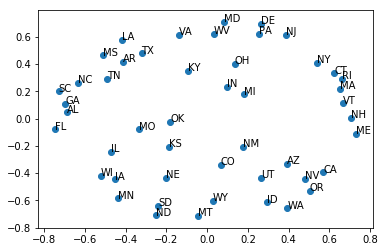

In [244]:
plt.scatter(XX[:, 0], XX[:, 1])
for i in range(48):
    s = adjecency_matrix.index[i]
    xx = XX[i]
    plt.annotate(s, xx)

In [245]:
pseudospace = pd.DataFrame.from_records(XX)
pseudospace.index = adjecency_matrix.index
pseudospace = pseudospace.loc[states.index]

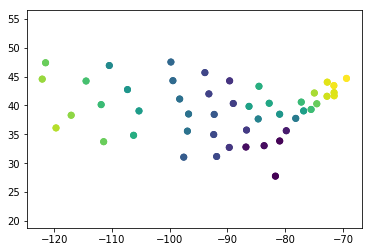

In [247]:
plt.scatter(states.Longitude, states.Latitude, c=pseudospace[0])
plt.axis('equal');

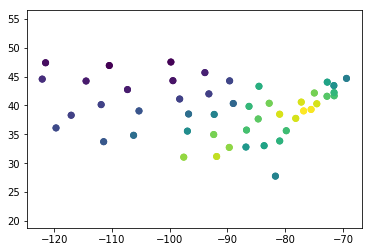

In [249]:
plt.scatter(states.Longitude, states.Latitude, c=pseudospace[1])
plt.axis('equal');

In [273]:
bills = pd.read_csv('all_bills.csv', index_col=0)
bills.title.str.split('; ').str.get(-1).head()

1                       In the nature of a substitute.
2    A bill to extend the termination date of the T...
3          A bill to approve the Keystone XL Pipeline.
4    To ensure that oil transported through the Key...
5    To require the use of iron, steel, and manufac...
Name: title, dtype: object

In [250]:
import SpatialDE

In [251]:
DE_mll_results = pd.DataFrame({'g': votes.index})
pattern_results, patterns = SpatialDE.spatial_patterns(pseudospace.values, votes.T, DE_mll_results, 3)

INFO:root:Iteration 1, log likelihood: -1627.87
INFO:root:Iteration 2, log likelihood: -1518.87
INFO:root:Iteration 3, log likelihood: -1502.13
INFO:root:Iteration 4, log likelihood: -1515.06
INFO:root:Iteration 5, log likelihood: -1513.82
INFO:root:Iteration 6, log likelihood: -1513.22
INFO:root:Converged! Finishing...
INFO:root:Iteration 7, log likelihood: -1513.12


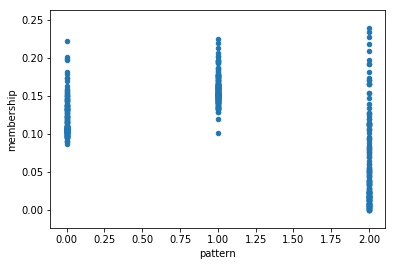

In [252]:
pattern_results.plot(x='pattern', y='membership', kind='scatter');

In [324]:
def plot_pattern(c):
    plt.scatter(states.Longitude, states.Latitude, c=patterns[c], s=100)
    plt.axis('equal');

    pattern_bills = pattern_results.query('pattern == {}'.format(c)).sort_values('membership')
    idx = pattern_bills.g.str.split(' ').str.get(-1).astype(int).head(15).values
    plt.xlabel('\n'.join(bills.iloc[idx].title.str.split('; ').str.get(-1).str.slice(0, 49)),
               fontsize=13, ha='left', x=0);
    
    plt.title('Senate pattern {}'.format(c + 1))

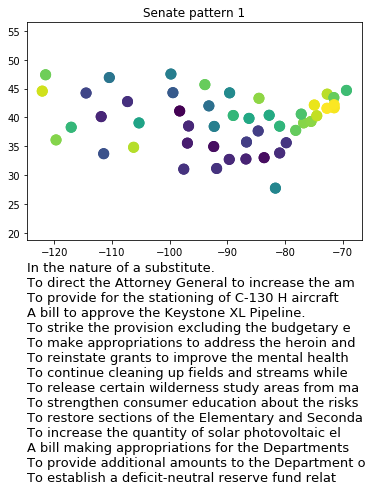

In [325]:
plot_pattern(0)

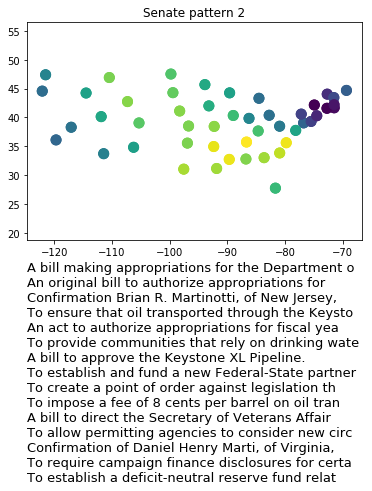

In [326]:
plot_pattern(1)

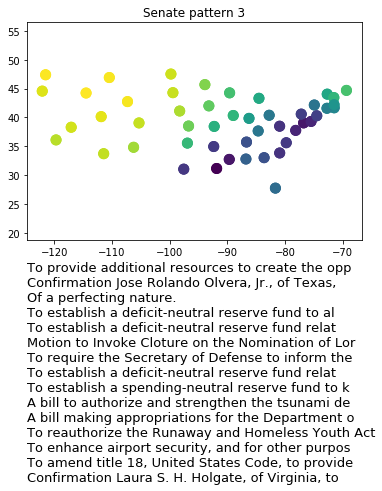

In [327]:
plot_pattern(2)